# Make animations
This notebook details how videos for my contribution are made. I use the package moviepy.

In [1]:
from moviepy import editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage

## Import data

In [2]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

Let's import module created to work with Metrica tracking data. These modules are mainly inspired by Laurie Shaw's tutorials.

In [3]:
from scripts import Metrica_Viz as mviz
from scripts import Metrica_Velocities as mvel

Import Last Row dataset to have plays list

In [4]:
LR_data = pd.read_csv('data_inputs/liverpool_analytics_2019.csv')

For each play, import :
* tracking home --> tracking data for home players (by default liverpool players)
* tracking away --> tracking data for away players
* players_num --> dataframe that associates playersId with their nums
* events --> events data
* off_ball_scoring --> an array of list. Length = nb frames. Each list corresponds to a frame and contains :
    * first item : pitch control surface
    * second item : off ball scoring opportunity surface
    * third item : a dictionnary. Each key is a player and contains pitch control surface for this player
    
Tracking home, away, players_num and events are generated when converting the data.
off_ball_scoring is generated with the script liverpool_analytics_calculate_off_ball_scoring.py

Let's construct a dictionnary plays data containing for each play the data mentionned above.

In [5]:
#plays list
plays = LR_data.play.unique()

#initialize dictionnary
plays_data = {}
for play in plays:
    tracking_home = pd.read_csv('data_inputs/'+play.replace(' ','_')+'/tracking_home.csv')
    tracking_away = pd.read_csv('data_inputs/'+play.replace(' ','_')+'/tracking_away.csv')
    players_num = pd.read_csv('data_inputs/'+play.replace(' ','_')+'/players_num.csv')
    events = pd.read_csv('data_inputs/'+play.replace(' ','_')+'/events.csv')
    try :
        off_ball_scoring = pickle.load(open('data_inputs/'+play.replace(' ','_')+'/off_ball_scoring', 'rb'))
    except:
        plays_data[play] = {'tracking_home':tracking_home}
        plays_data[play]['tracking_away'] = tracking_away
        plays_data[play]['players_num'] = players_num
        plays_data[play]['events'] = events
    else:
        plays_data[play] = {'tracking_home':tracking_home}
        plays_data[play]['tracking_away'] = tracking_away
        plays_data[play]['players_num'] = players_num
        plays_data[play]['events'] = events
        plays_data[play]['off_ball_scoring'] = off_ball_scoring

## Liverpool [2] - 1 Newcastle pitch control video

In [6]:
play = 'Liverpool [2] - 1 Newcastle'
tracking_home = plays_data[play]['tracking_home']
tracking_away = plays_data[play]['tracking_away']
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')
off_ball = plays_data[play]['off_ball_scoring']
players_num = plays_data[play]['players_num']
players_to_annotate = players_num.dropna()

In [7]:
def plot_pitch_control_for_frame(frame,off_ball,figax,n_grid_cells_x = 50, field_dimen = (106.0,68.0)):
    
    pitch_control = off_ball[int(frame/2)][0]
    fig,ax=figax
    
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., n_grid_cells_x)
    ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y)
    
    cmap = 'bwr'
    im=ax.imshow(np.flipud(pitch_control), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=1.0,cmap=cmap,alpha=0.5)
    fig.colorbar(im)
    ax.text(0,34+0.25,'Liverpool pitch control: '+str(round(np.sum(pitch_control)/32/50*100,2))+'%',fontsize=12)
    
    return(fig,ax)

In [8]:
def draw_frame_x(hometeam,awayteam, off_ball, t, players_to_annotate, figax=None, fps=25, 
                 team_colors=('r','b'), field_dimen = (106.0,68.0), 
                 include_player_velocities=True, PlayerMarkerSize=10, PlayerAlpha=0.7,dpi=100):
    
    #we have to convert t*fps to int because t is a float
    fig,ax=mviz.plot_pitch(field_color='white')
    fig,ax=mviz.plot_frame(hometeam.iloc[int(t*fps)], awayteam.iloc[int(t*fps)], figax=(fig,ax), 
                           team_colors=team_colors, field_dimen = field_dimen, 
                           include_player_velocities=include_player_velocities, PlayerMarkerSize=PlayerMarkerSize, PlayerAlpha=PlayerAlpha)
    
    fig,ax=plot_pitch_control_for_frame(int(t*fps),off_ball,(fig,ax))
    
    players_id=players_to_annotate.iloc[:,0].values
    nums=players_to_annotate.iloc[:,1].values
    for k in range(len(nums)):
        ax.text(hometeam.iloc[int(t*fps)]['Home_'+str(players_id[k])+'_x'],hometeam.iloc[int(t*fps)]['Home_'+str(players_id[k])+'_y'],str(int(nums[k])),fontsize=10,color='k',horizontalalignment='center', verticalalignment='center')
    
    image = mplfig_to_npimage(fig)
    plt.close()
    return image

In [9]:
def make_animation(hometeam,awayteam,off_ball, fpath, players_to_annotate, fname='clip_test', figax=None, fps=25, 
                   team_colors=('r','b'), field_dimen = (106.0,68.0), 
                   include_player_velocities=True, PlayerMarkerSize=15, PlayerAlpha=0.7,dpi=100):
    
    length=len(hometeam)/fps

    clip = mpy.VideoClip(
        lambda x: draw_frame_x(hometeam, awayteam, off_ball, x, players_to_annotate, figax=figax, team_colors=team_colors, field_dimen = field_dimen, include_player_velocities=include_player_velocities, PlayerMarkerSize=PlayerMarkerSize, PlayerAlpha=PlayerAlpha),
        duration=length).set_fps(fps)

    clip.write_videofile(fpath+fname+'.mp4')

t:   0%|          | 0/149 [00:00<?, ?it/s, now=None]

Moviepy - Building video data_outputs/Liverpool_[2]_-_1_Newcastle.mp4.
Moviepy - Writing video data_outputs/Liverpool_[2]_-_1_Newcastle.mp4



t:  42%|████▏     | 62/149 [00:18<00:22,  3.90it/s, now=None]

KeyboardInterrupt: 

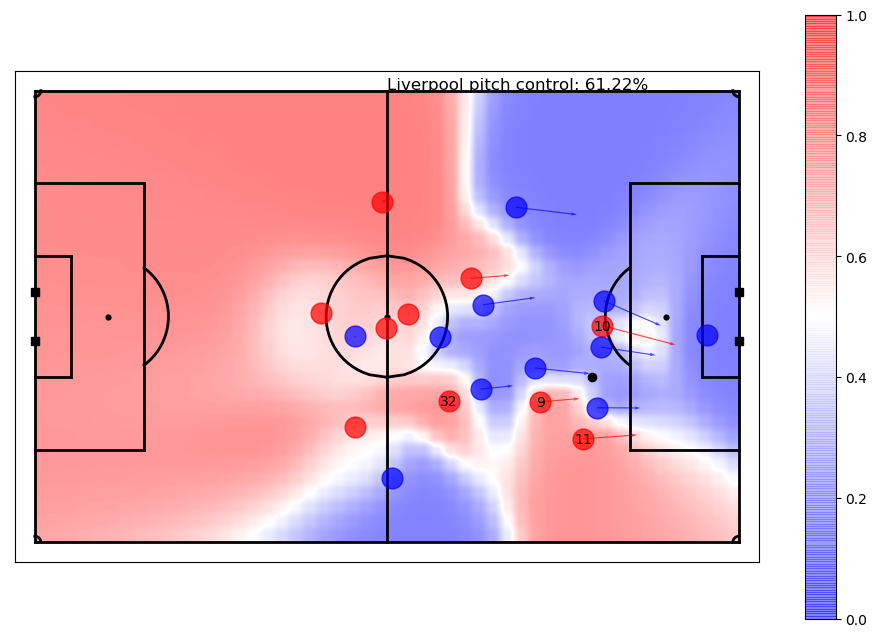

In [10]:
make_animation(tracking_home,tracking_away,off_ball, 'data_outputs/', players_to_annotate, fname='Liverpool_[2]_-_1_Newcastle')

## Liverpool [2] - 0 Porto pitch control video

In [6]:
play = 'Liverpool [2] - 0 Porto'
tracking_home = plays_data[play]['tracking_home']
tracking_away = plays_data[play]['tracking_away']
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')
off_ball = plays_data[play]['off_ball_scoring']
players_num = plays_data[play]['players_num']
players_to_annotate = players_num.dropna()

KeyboardInterrupt: 

In [ ]:
make_animation(tracking_home,tracking_away,off_ball, 'data_outputs/', players_to_annotate, fname='Liverpool [2] - 0 Porto')

## 3 Crosses goals

In [9]:
# cross plays list
cross_plays=['Liverpool [2] - 0 Porto','Liverpool [1] - 0 Wolves','Liverpool [2] - 0 Salzburg']

# scorers num
scorers=['13','1776','12']
scorers_names=['Firmino','Mane','Robertson']

def draw_frame_x_2(t,fps=20):
    
    frame=int(t*fps)

    # creat subplots
    fig,ax=plt.subplots(1,3,figsize=(35,8),dpi=120)

    for k in range(3):

        play=cross_plays[k]
        tracking_home = plays_data[play]['tracking_home']
        tracking_away = plays_data[play]['tracking_away']
        events = plays_data[play]['events']
        tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
        tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')
        off_ball = plays_data[play]['off_ball_scoring']
        players_num = plays_data[play]['players_num']
        
        mviz.plot_pitch(field_color='white',figax=(fig,ax[k]))
        
        if frame<len(tracking_home):

            #cross frame
            cross_frame=int(events.query('Type=="PASS"')['Start Frame'].max())

            
            #ball's legend
            ax[k].plot(0,0,'ko',label="ball's position")

            # title
            ax[k].set_title(play,fontsize=20)

            off_ball_scoring_opp=off_ball[int(frame/2)][1]

            play=cross_plays[k]
            mviz.plot_frame(tracking_home.iloc[frame],tracking_away.iloc[frame],figax=(fig,ax[k]),annotate=False,include_player_velocities=False,PlayerMarkerSize=15,PlayerAlpha=0.7)
            
            # plot scorer
            x = tracking_home['Home_'+scorers[k]+'_x'].iloc[:cross_frame+1]
            y = tracking_home['Home_'+scorers[k]+'_y'].iloc[:cross_frame+1]
            ax[k].plot(x,y,'r',linewidth=3,label=scorers_names[k]+"'s move")
            ax[k].plot(tracking_home['Home_'+scorers[k]+'_x'].iloc[frame],tracking_home['Home_'+scorers[k]+'_y'].iloc[frame],'wo',markersize=5)

            #legend
            ax[k].legend(loc='upper center',fontsize=15)
            
            field_dimen = (106.,68.,)
            n_grid_cells_x = 50
            n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
            xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., n_grid_cells_x)
            ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y)
            cmap = 'Reds'#plt.cm.Reds
            im=ax[k].imshow(np.flipud(off_ball_scoring_opp), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,vmax=0.15,cmap=cmap,alpha=1)

    image = mplfig_to_npimage(fig)
    plt.close()
    return image

In [10]:
def make_animation_2(fpath, fname='clip_test', figax=None, fps=25, 
                   team_colors=('r','b'), field_dimen = (106.0,68.0), 
                   include_player_velocities=True, PlayerMarkerSize=15, PlayerAlpha=0.7,dpi=100):
    
    length=210/fps

    clip = mpy.VideoClip(
        lambda x: draw_frame_x_2(x),
        duration=length).set_fps(fps)

    clip.write_videofile(fpath+fname+'.mp4')

In [11]:
make_animation_2('data_outputs/', fname='crosses')

t:   0%|          | 0/210 [00:00<?, ?it/s, now=None]

Moviepy - Building video data_outputs/crosses.mp4.
Moviepy - Writing video data_outputs/crosses.mp4



Moviepy - Done !
Moviepy - video ready data_outputs/crosses.mp4
